# Setup

In [1]:
from array import array
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory
from metrics import ConfusionMatrixGenerator
from joblib import dump
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'program_comprehension_challenge'
report_dict_list = []

In [2]:
X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)

# Show the datasets value counts
dataset_dict = {}
dataset_dict['Training Dataset'] = len(training_dataset.loc[training_dataset[LABEL] == "Yes"]), len(training_dataset.loc[training_dataset[LABEL] == "No"]), len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset)
dataset_dict['Test Dataset'] = len(test_dataset.loc[test_dataset[LABEL] == "Yes"]), len(test_dataset.loc[test_dataset[LABEL] == "No"]), len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset)
df = DataFrame.from_dict(dataset_dict, orient='index', columns=['Label (Yes)', 'Label (No)', 'Ratio (Yes)'])

df

,Label (Yes),Label (No),Ratio (Yes)
Training Dataset,92,506,0.153846
Test Dataset,39,111,0.260000


# Set up

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from nlp import LemmaTokenizer
from metrics import ConfusionMatrixGenerator

is_author_categories = [
    False,  # 0 should come before 1 for numerical columns.
    True
]

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True, ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

# TFIDF - Lemmatization - SGDClassifier

In [4]:
from sklearn.linear_model import SGDClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SGDClassifier(random_state=13))
    ],
    verbose=False)

clf_sgd = full_pipeline

clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier': report})

# TFIDF - Lemmatization - MultinomialNB

In [5]:
from sklearn.naive_bayes import MultinomialNB

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB': report})

# TFIDF - Lemmatization - LogisticRegression

In [6]:
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression(C=500000, solver='liblinear', multi_class='ovr', intercept_scaling=1, dual=True, penalty='l2'))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression': report})

# Report Performance Before Grid Search (as it is time consuming)

In [7]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'yes_fb_score': [next(iter(report.values()))['Yes']['F-beta Score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,yes_fb_score,Accuracy
0,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.748663,0.866667
1,TFIDF - Lemmatization - MultinomialNB,0.740000,1.000000,0.850575,0.000000,0.000000,0.000000,0.000000,0.740000
2,TFIDF - Lemmatization - LogisticRegression,0.840000,0.945946,0.889831,0.760000,0.487179,0.593750,0.683453,0.826667


In [8]:
yes_fbeta_precision_scorer = metrics.make_scorer(metrics.fbeta_score, beta=0.5, pos_label='Yes')

# Tuning the model with Grid Search - MultinomialNB

In [9]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            MultinomialNB()
        )
    ],
    verbose=False)

grid_search_cv_params = [
    {
        'classifier__alpha': [0, 1.5, 1, 2, 10],
        'classifier__fit_prior': [True, False],
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


{'classifier__alpha': 0, 'classifier__fit_prior': True}

In [10]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.080977,1.840693,1.005119,1.755908,0,True,"{'classifier__alpha': 0, 'classifier__fit_prio...",0.638298,0.581395,0.454545,0.3,0.500000,0.494848,0.116349,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,6.396908,3.306307,0.980133,1.703635,0,False,"{'classifier__alpha': 0, 'classifier__fit_prio...",0.588235,0.531915,0.454545,0.3,0.500000,0.474939,0.097704,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,4.098027,1.745773,1.015809,1.767159,1.5,True,"{'classifier__alpha': 1.5, 'classifier__fit_pr...",0.000000,0.370370,0.227273,0.0,0.384615,0.196452,0.169582,4,0.942761,0.950820,0.969697,0.947712,0.988701,0.959938,0.017030
3,4.130385,1.731068,1.053014,1.800932,1.5,False,"{'classifier__alpha': 1.5, 'classifier__fit_pr...",0.000000,0.370370,0.227273,0.0,0.384615,0.196452,0.169582,4,0.969231,0.975976,0.985714,0.979532,1.000000,0.982091,0.010423
4,4.296675,1.856940,1.042948,1.806598,1,True,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.000000,0.370370,0.227273,0.0,0.384615,0.196452,0.169582,4,0.985507,0.985507,0.991620,0.991620,1.000000,0.990851,0.005329
5,4.313270,1.816156,1.038216,1.812201,1,False,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.217391,0.370370,0.333333,0.0,0.500000,0.284219,0.168310,3,0.991501,0.994398,0.997268,0.994475,1.000000,0.995528,0.002885
6,4.219608,1.827261,0.958252,1.677184,2,True,"{'classifier__alpha': 2, 'classifier__fit_prio...",0.000000,0.370370,0.227273,0.0,0.000000,0.119529,0.153226,8,0.796020,0.777202,0.833333,0.800971,0.969697,0.835445,0.069517
7,3.932526,1.667102,0.928570,1.616421,2,False,"{'classifier__alpha': 2, 'classifier__fit_prio...",0.000000,0.370370,0.227273,0.0,0.384615,0.196452,0.169582,4,0.920578,0.920578,0.947712,0.926573,0.991620,0.941412,0.027014
8,3.854043,1.655651,0.959836,1.684568,10,True,"{'classifier__alpha': 10, 'classifier__fit_pri...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,3.713439,1.602669,0.838269,1.466997,10,False,"{'classifier__alpha': 10, 'classifier__fit_pri...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,9,0.123457,0.000000,0.000000,0.121951,0.222222,0.093526,0.084570


In [11]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'GridSearch MultinomialNB': report})

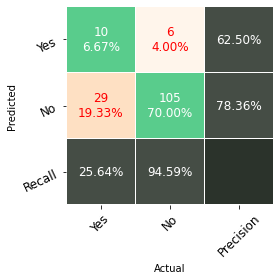

In [12]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=['Yes', 'No'])
ConfusionMatrixGenerator.print_confusion_matrix(cm, ["Yes", "No"], figsize=[4, 4], number_formatting='.2f', font_size=12)

# Tuning the model with Grid Search - LogisticRegression

In [13]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            LogisticRegression()
        )
    ],
    verbose=False)

grid_search_cv_params = [
    {
        'classifier__C': [0, 1, 10, 500000],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'classifier__multi_class': ['auto', 'ovr', 'multinomial'],
        # 'classifier__intercept_scaling': [0, 0.5, 1, 10],
        'classifier__dual': [True, False],
        # 'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.4min finished


{'classifier__C': 500000,
 'classifier__dual': False,
 'classifier__multi_class': 'multinomial',
 'classifier__solver': 'sag'}

In [14]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__dual,param_classifier__multi_class,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.913589,1.689641,0.000000,0.000000,0,True,auto,newton-cg,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.868592,1.672562,0.000000,0.000000,0,True,auto,lbfgs,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.405473,1.949588,0.000000,0.000000,0,True,auto,liblinear,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.435558,1.950546,0.000000,0.000000,0,True,auto,sag,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.770848,1.630596,0.000000,0.000000,0,True,auto,saga,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.741129,1.611922,0.000000,0.000000,0,True,ovr,newton-cg,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.684909,1.577810,0.000000,0.000000,0,True,ovr,lbfgs,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.825476,1.613763,0.000000,0.000000,0,True,ovr,liblinear,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.273705,1.763121,0.000000,0.000000,0,True,ovr,sag,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.965351,1.742969,0.000000,0.000000,0,True,ovr,saga,"{'classifier__C': 0, 'classifier__dual': True,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'GridSearch LogisticRegression': report})

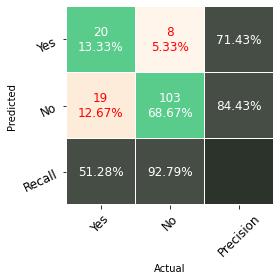

In [16]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=['Yes', 'No'])
ConfusionMatrixGenerator.print_confusion_matrix(cm, ["Yes", "No"], figsize=[4, 4], number_formatting='.2f', font_size=12)

# Tuning the model with Grid Search - SGDClassifier

In [17]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            SGDClassifier()
        )
    ],
    verbose=False)

grid_search_cv_params = [
    {
        'classifier__random_state': list(range(1, 20)),
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.6min finished


{'classifier__random_state': 18}

In [18]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.431336,1.466813,0.811251,1.416105,1,{'classifier__random_state': 1},0.722892,0.662651,0.518868,0.731707,0.806452,0.688514,0.096338,7,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
1,3.488185,1.508852,0.863797,1.514933,2,{'classifier__random_state': 2},0.783133,0.630631,0.566038,0.555556,0.755814,0.658234,0.094791,15,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
2,3.574392,1.536620,0.882498,1.530432,3,{'classifier__random_state': 3},0.733333,0.630631,0.508475,0.731707,0.833333,0.687496,0.110097,9,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
3,3.570271,1.548272,0.844427,1.473626,4,{'classifier__random_state': 4},0.677966,0.695652,0.612245,0.743243,0.705128,0.686847,0.042980,10,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
4,3.516707,1.512019,0.849998,1.472800,5,{'classifier__random_state': 5},0.759494,0.700935,0.612245,0.743243,0.697674,0.702718,0.051146,3,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
5,3.492777,1.513998,0.871163,1.524915,6,{'classifier__random_state': 6},0.634921,0.632184,0.471014,0.645161,0.757576,0.628171,0.091427,19,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
6,3.539776,1.528736,0.846850,1.477515,7,{'classifier__random_state': 7},0.696203,0.631579,0.570175,0.614035,0.725806,0.647560,0.056314,16,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
7,3.601184,1.543392,0.941012,1.658658,8,{'classifier__random_state': 8},0.783133,0.656566,0.611111,0.648148,0.862069,0.712205,0.094772,2,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
8,3.770960,1.606461,0.859717,1.492024,9,{'classifier__random_state': 9},0.746269,0.630631,0.590909,0.731707,0.725806,0.685064,0.062305,11,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
9,3.555356,1.530506,0.865394,1.509123,10,{'classifier__random_state': 10},0.714286,0.630631,0.570175,0.689655,0.833333,0.687616,0.088305,8,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000


In [19]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'GridSearch SGDClassifier': report})

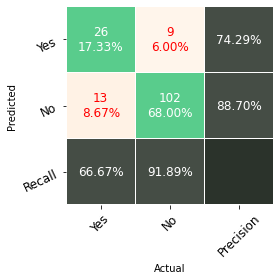

In [20]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=['Yes', 'No'])
ConfusionMatrixGenerator.print_confusion_matrix(cm, ["Yes", "No"], figsize=[4, 4], number_formatting='.2f', font_size=12)

# Performance Result Comparison

In [21]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'yes_fb_score': [next(iter(report.values()))['Yes']['F-beta Score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,yes_fb_score,Accuracy
0,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.748663,0.866667
1,TFIDF - Lemmatization - MultinomialNB,0.740000,1.000000,0.850575,0.000000,0.000000,0.000000,0.000000,0.740000
2,TFIDF - Lemmatization - LogisticRegression,0.840000,0.945946,0.889831,0.760000,0.487179,0.593750,0.683453,0.826667
3,GridSearch MultinomialNB,0.783582,0.945946,0.857143,0.625000,0.256410,0.363636,0.485437,0.766667
4,GridSearch LogisticRegression,0.844262,0.927928,0.884120,0.714286,0.512821,0.597015,0.662252,0.820000
5,GridSearch SGDClassifier,0.886957,0.918919,0.902655,0.742857,0.666667,0.702703,0.726257,0.853333


# Performance Result Comparison

In [22]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'yes_fb_score': [next(iter(report.values()))['Yes']['F-beta Score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,yes_fb_score,Accuracy
0,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.748663,0.866667
1,TFIDF - Lemmatization - MultinomialNB,0.740000,1.000000,0.850575,0.000000,0.000000,0.000000,0.000000,0.740000
2,TFIDF - Lemmatization - LogisticRegression,0.840000,0.945946,0.889831,0.760000,0.487179,0.593750,0.683453,0.826667
3,GridSearch MultinomialNB,0.783582,0.945946,0.857143,0.625000,0.256410,0.363636,0.485437,0.766667
4,GridSearch LogisticRegression,0.844262,0.927928,0.884120,0.714286,0.512821,0.597015,0.662252,0.820000
5,GridSearch SGDClassifier,0.886957,0.918919,0.902655,0.742857,0.666667,0.702703,0.726257,0.853333


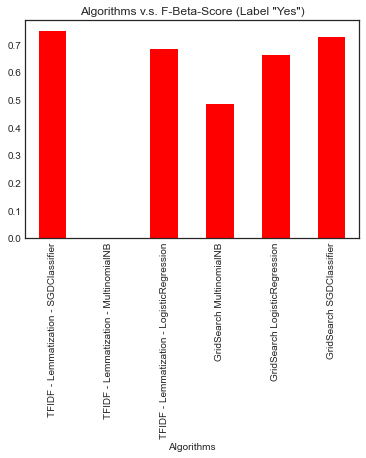

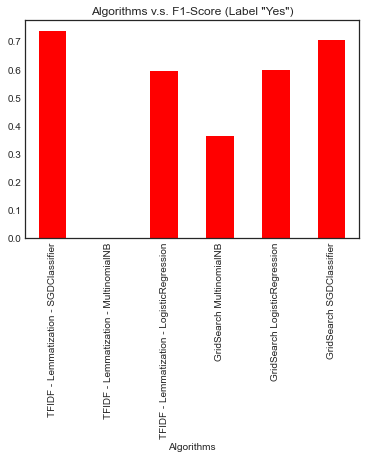

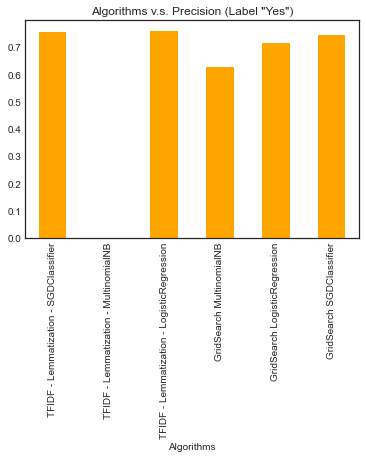

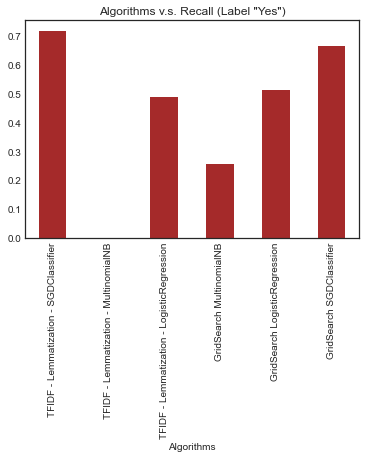

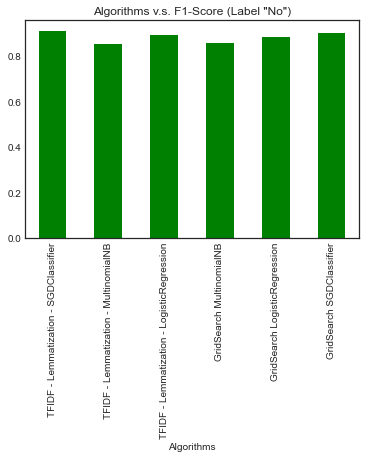

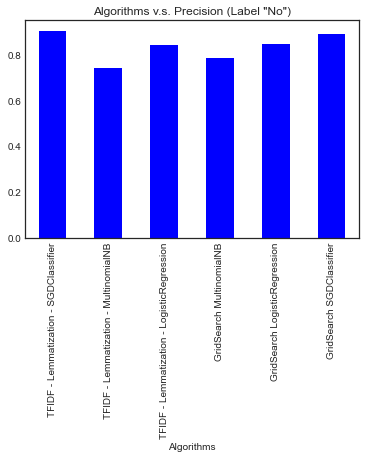

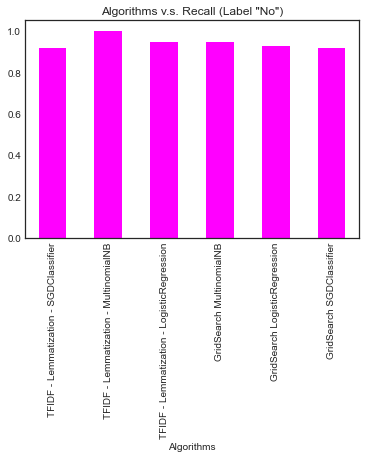

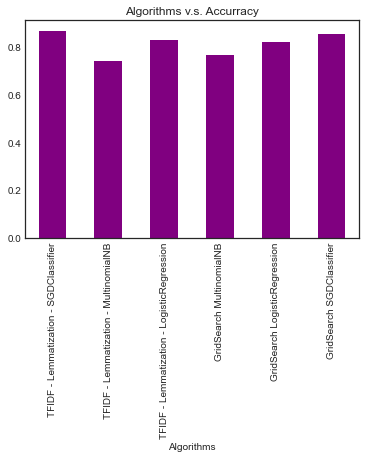

In [23]:
from matplotlib import pyplot

with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_fb_score', rot=90, title='Algorithms v.s. F-Beta-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)